In [1]:
!pip install tensorflow --upgrade --quiet
!yes | apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.11.0 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow<2.7.0,>=2.6.0, but you have tensorflow 2.11.0 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, but you have tensorflow-io-gcs-filesystem 0.29.0 which is incompatible.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 91 not upgraded.
Need to get 430 MB of archives.
After this operation, 2506 MB

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')



2023-01-03 04:04:45.174079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-03 04:04:46.769134: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-03 04:04:46.769391: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Co

In [3]:
def get_data(dataset,mode):
    image_size = (100, 100)
    batch = 32
    if mode=='train':
        sbst='training'
        vs=.003
    if mode=='test':
        sbst='validation'
        vs=.99
    data = keras.preprocessing.image_dataset_from_directory(
        dataset,
        validation_split=vs,
        subset=sbst,
        seed=42,
        image_size=image_size,
        batch_size=batch,
        label_mode='categorical'
    )
    return data


def display_samples(dataset, n_samples, classes_name):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(n_samples):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(classes_name[np.argmax(labels[i])])
            plt.axis("off")
            
            
def data_augumentation(data):
    fig, ax = plt.subplots(5, 3, figsize=(6,14))
    for images, labels in data.take(1):
        for i in range(3):
            # original
            ax[0][i].imshow(images[i].numpy().astype("uint8"))
            ax[0][i].set_title("original")
            # resize

            ax[1][i].imshow(tf.image.resize(images[i], [100,100]).numpy().astype("uint8"))
            ax[1][i].set_title("resize")
            # crop

            ax[2][i].imshow(tf.image.crop_to_bounding_box(images[i], 0, 0, 100, 100).numpy().astype("uint8"))
            ax[2][i].set_title("crop")
            # central crop
            x = tf.random.uniform([], minval=0.4, maxval=1.0)
            ax[3][i].imshow(tf.image.central_crop(images[i], x).numpy().astype("uint8"))
            ax[3][i].set_title("central crop")
            # crop to (h,w) at random offset

            seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype("int32")
            ax[4][i].imshow(tf.image.stateless_random_crop(images[i], [100,100,3], seed).numpy().astype("uint8"))
            ax[4][i].set_title("random crop")
    plt.show()

    fig, ax = plt.subplots(4, 3, figsize=(6,14))
    for images, labels in data.take(1):
        for i in range(3):
            #ax[0][i].imshow(images[i].numpy().astype("uint8"))
            #ax[0][i].set_title("original")
            # flip
            seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype("int32")
            ax[0][i].imshow(tf.image.stateless_random_flip_left_right(images[i], seed).numpy().astype("uint8"))
            ax[0][i].set_title("flip left-right")
            # flip
            seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype("int32")
            ax[1][i].imshow(tf.image.stateless_random_flip_up_down(images[i], seed).numpy().astype("uint8"))
            ax[1][i].set_title("flip up-down")
            # sobel edge
            sobel = tf.image.sobel_edges(images[i:i+1])
            ax[2][i].imshow(sobel[0, ..., 0].numpy().astype("uint8"))
            ax[2][i].set_title("sobel y")
            # sobel edge
            ax[3][i].imshow(sobel[0, ..., 1].numpy().astype("uint8"))
            ax[3][i].set_title("sobel x")
    plt.show()

    fig, ax = plt.subplots(4, 3, figsize=(6,14))
    for images, labels in data.take(1):
        for i in range(3):
            #ax[0][i].imshow(images[i].numpy().astype("uint8"))
            #ax[0][i].set_title("original")
            # brightness
            seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype("int32")
            ax[0][i].imshow(tf.image.stateless_random_brightness(images[i], 0.3, seed).numpy().astype("uint8"))
            ax[0][i].set_title("brightness")
            # contrast
            ax[1][i].imshow(tf.image.stateless_random_contrast(images[i], 0.7, 1.3, seed).numpy().astype("uint8"))
            ax[1][i].set_title("contrast")
            # saturation
            ax[2][i].imshow(tf.image.stateless_random_saturation(images[i], 0.7, 1.3, seed).numpy().astype("uint8"))
            ax[2][i].set_title("saturation")
            # hue
            ax[3][i].imshow(tf.image.stateless_random_hue(images[i], 0.3, seed).numpy().astype("uint8"))
            ax[3][i].set_title("hue")
    plt.show()


In [4]:
image_size = (100, 100)
train_path='/kaggle/input/butterfly-dataset/Butterfly/train/'
test_path='/kaggle/input/butterfly-dataset/Butterfly/test/'

In [5]:
train=get_data(train_path,'train')
validation=get_data(test_path,'test')

Found 480 files belonging to 6 classes.
Using 479 files for training.
Found 151 files belonging to 6 classes.
Using 149 files for validation.


--------*-----train-----*---------


2023-01-03 04:04:56.487598: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 59346432 exceeds 10% of free system memory.


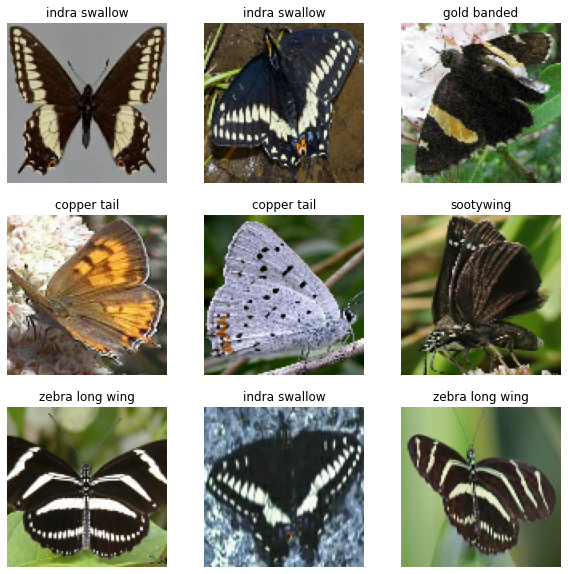

In [6]:
print("--------*-----train-----*---------")
display_samples(train, 9, train.class_names)

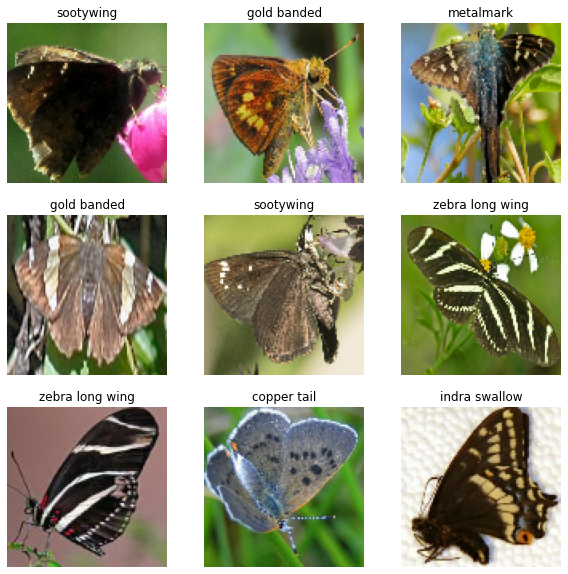

In [7]:
display_samples(validation, 9, validation.class_names)

In [8]:
class_names = train.class_names
labels = np.array([])
for _, label in train:
    clear_output(wait=True)
    labels = np.concatenate((labels, np.argmax(label, axis=-1)))
_, counts = np.unique(labels, return_counts=True)
print(counts)
print(_,)

[80 79 80 80 80 80]
[0. 1. 2. 3. 4. 5.]


In [9]:
total = counts.sum()
print("Frequency of each piece")
for i in range(len(counts)):
    print(f'{class_names[i]}: {counts[i]}({counts[i] / total:.2f}%)')

Frequency of each piece
copper tail: 80(0.17%)
gold banded: 79(0.16%)
indra swallow: 80(0.17%)
metalmark: 80(0.17%)
sootywing: 80(0.17%)
zebra long wing: 80(0.17%)


In [10]:
input_shape=(image_size[0], image_size[1], 3)
reg = keras.regularizers.l2(0.0001)
model1 = keras.Sequential()
model1.add(Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=image_size + (3,), kernel_regularizer=reg))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Conv2D(66, (3, 3), padding="same", activation="relu", kernel_regularizer=reg))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())

model1.add(Dense(len(train.class_names), activation='softmax'))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 66)        38082     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 66)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 41250)             0         
                                                                 
 dense (Dense)               (None, 6)                 2

In [11]:
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
callbacks = [EarlyStopping(monitor='val_acc', patience=5, verbose=2), ModelCheckpoint('checkpoints/weights.{epoch:02d}.hdf5', save_best_only=True), TensorBoard('~/notebooks/logs',
                                                                                      write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)]



In [12]:
batch_size = 100
epochs = 5


model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model1.fit(
    train,
    epochs=epochs,
    validation_data=validation,
    callbacks=callbacks)

Epoch 1/5


2023-01-03 04:05:03.365321: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 59346432 exceeds 10% of free system memory.
2023-01-03 04:05:05.050663: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-03 04:05:07.447897: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-03 04:05:07.615084: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are usin

15/15 [==============================] - 8s 114ms/step - loss: 141.6208 - accuracy: 0.2150 - val_loss: 1.7210 - val_accuracy: 0.2685
Epoch 2/5
 1/15 [=>............................] - ETA: 12s - loss: 1.2602 - accuracy: 0.4688

2023-01-03 04:05:11.050536: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 59346432 exceeds 10% of free system memory.


15/15 [==============================] - 2s 83ms/step - loss: 1.2350 - accuracy: 0.4990 - val_loss: 1.6324 - val_accuracy: 0.3356
Epoch 3/5
 1/15 [=>............................] - ETA: 13s - loss: 0.9932 - accuracy: 0.5625

2023-01-03 04:05:13.157396: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 59346432 exceeds 10% of free system memory.


15/15 [==============================] - 2s 86ms/step - loss: 0.7023 - accuracy: 0.7328 - val_loss: 1.5091 - val_accuracy: 0.5906
Epoch 4/5
15/15 [==============================] - 2s 93ms/step - loss: 0.3146 - accuracy: 0.8935 - val_loss: 1.4086 - val_accuracy: 0.5705
Epoch 5/5
15/15 [==============================] - 3s 107ms/step - loss: 0.2222 - accuracy: 0.9332 - val_loss: 1.4377 - val_accuracy: 0.6174


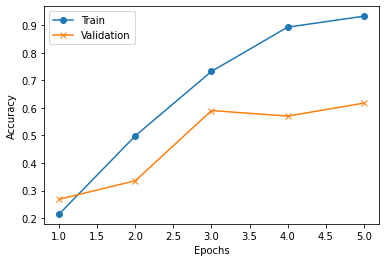

In [13]:
epochs_range = [i+1 for i in range(epochs)]
plt.plot(epochs_range, model1.history.history['accuracy'], '-o', label='Train')
plt.plot(epochs_range, model1.history.history['val_accuracy'], '-x',label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend();

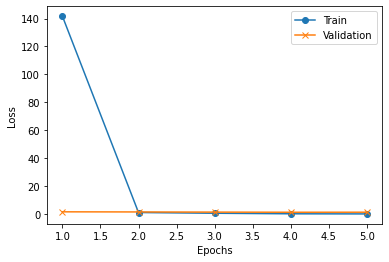

In [14]:
epochs_range = [i+1 for i in range(epochs)]
plt.plot(epochs_range, model1.history.history['loss'], '-o', label='Train')
plt.plot(epochs_range, model1.history.history['val_loss'], '-x',label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend();

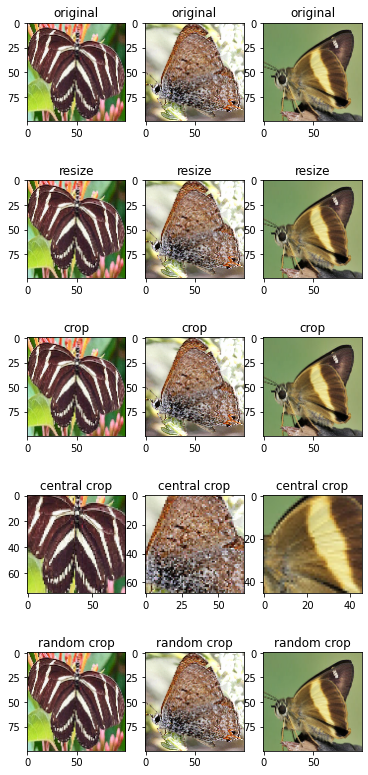

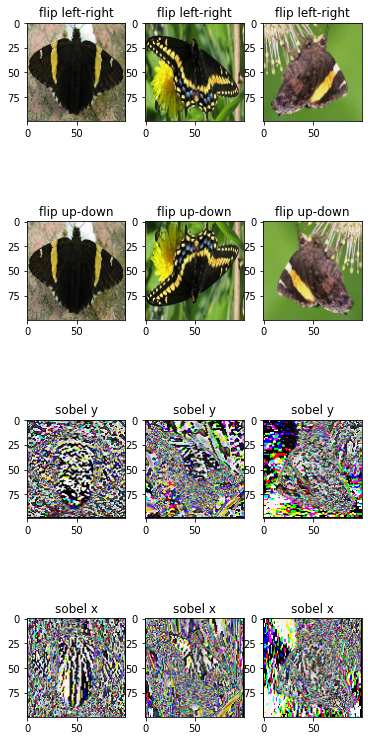

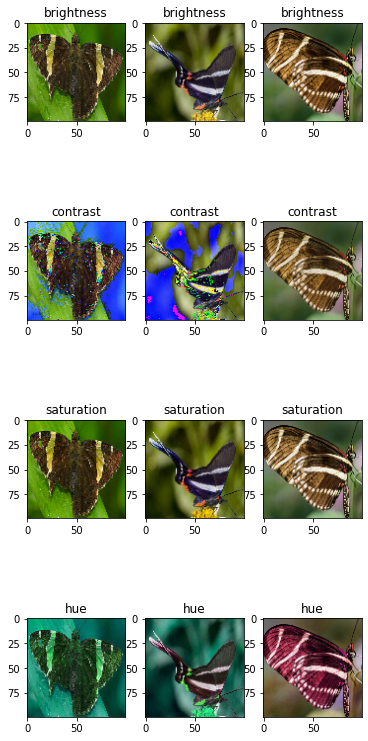

In [15]:
data_augumentation(train)

In [16]:
input_shape = (image_size[0], image_size[1], 3)
reg = keras.regularizers.l2(0.0005)

model = keras.Sequential()


model.add(Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=image_size + (3,), kernel_regularizer=reg))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same", activation="relu", kernel_regularizer=reg))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding="same", activation="relu", kernel_regularizer=reg))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(train.class_names), activation='softmax'))


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 128)     

In [17]:
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
callbacks = [EarlyStopping(monitor='val_acc', patience=5, verbose=2), ModelCheckpoint('checkpoints/weights.{epoch:02d}.hdf5', save_best_only=True), TensorBoard('~/notebooks/logs',
                                                                                      write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)]



In [18]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)


In [19]:
 
epochs = 10
print("========================\n",epochs,"\n===========================")
model.fit(
    train,
    epochs=epochs,
    validation_data=validation,
    callbacks=callbacks,
);


 10 
Epoch 1/10


2023-01-03 04:05:28.736480: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-01-03 04:05:30.207961: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2023-01-03 04:05:30.442107: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often suffic

15/15 [==============================] - 7s 159ms/step - loss: 1.6294 - accuracy: 0.5240 - val_loss: 20.2028 - val_accuracy: 0.4497
Epoch 2/10
15/15 [==============================] - 3s 116ms/step - loss: 0.7796 - accuracy: 0.7620 - val_loss: 12.5421 - val_accuracy: 0.2081
Epoch 3/10
15/15 [==============================] - 3s 116ms/step - loss: 0.5524 - accuracy: 0.8664 - val_loss: 9.4315 - val_accuracy: 0.2550
Epoch 4/10
15/15 [==============================] - 3s 121ms/step - loss: 0.4567 - accuracy: 0.9123 - val_loss: 4.4585 - val_accuracy: 0.5235
Epoch 5/10
15/15 [==============================] - 2s 111ms/step - loss: 0.3838 - accuracy: 0.9144 - val_loss: 2.5369 - val_accuracy: 0.5570
Epoch 6/10
15/15 [==============================] - 3s 123ms/step - loss: 0.2888 - accuracy: 0.9541 - val_loss: 1.6490 - val_accuracy: 0.6309
Epoch 7/10
15/15 [==============================] - 2s 113ms/step - loss: 0.2480 - accuracy: 0.9624 - val_loss: 1.4409 - val_accuracy: 0.6846
Epoch 8/10
15/1

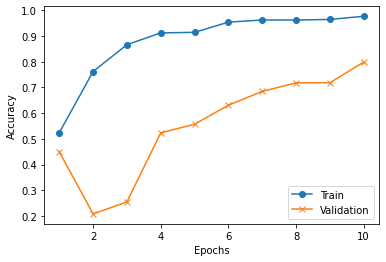

In [20]:
epochs_range = [i+1 for i in range(epochs)]
plt.plot(epochs_range, model.history.history['accuracy'], '-o', label='Train')
plt.plot(epochs_range, model.history.history['val_accuracy'], '-x',label='Validation')

plt.ylabel('Accuracy')
plt.xlabel('Epochs')

plt.legend();

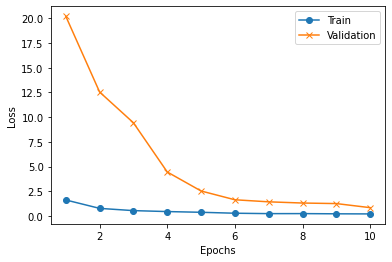

In [21]:
epochs_range = [i+1 for i in range(epochs)]
plt.plot(epochs_range, model.history.history['loss'], '-o', label='Train')
plt.plot(epochs_range, model.history.history['val_loss'], '-x',label='Validation')

plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.legend();